## For only 1 class

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import albumentations as albu
import torch
import segmentation_models_pytorch as smp
import time

DATA_DIR = 'E:\\few_data\\few_data\\'

# doesn't matter for inference
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['coal','bound']
ACTIVATION = 'softmax2d'
if torch.cuda.is_available():
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    DEVICE = 'cuda'
else:
    DEVICE = 'cpu'


model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)


In [13]:
if not os.path.exists(DATA_DIR + 'result/'):
    os.makedirs(DATA_DIR + 'result/')
path = DATA_DIR + "result/"

image_name = '20210712_141048_857A_ACCC8EAF31F3_0.jpg'
image_path = DATA_DIR + 'test/' + image_name
threshold = 0.45

best_model = torch.load('./best_model3.pth')
best_model.eval();

Elapsed time, s: 0.06600451469421387


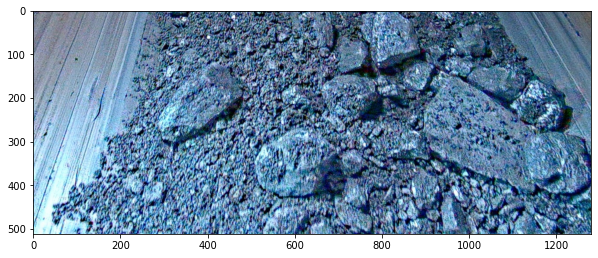

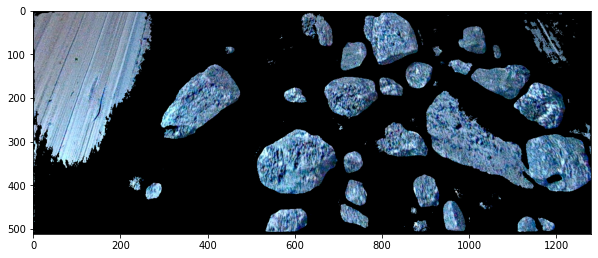

In [14]:
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
orig = image.copy().astype('float32')
orig_int = image.copy()

trf = albu.Compose([albu.Lambda(image=preprocessing_fn)])
image = trf(image=image)['image']
image = image.transpose(2, 0, 1).astype('float32')

x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
start = time.time()
pr_mask = best_model.predict(x_tensor).squeeze(0).cpu().numpy()
end = time.time()
print("Elapsed time, s:",end - start)
pr_mask_norm = np.where(pr_mask > threshold, 0, 255)
pr_mask_norm = pr_mask_norm.transpose(1,2,0)

mask, edges = cv2.split(pr_mask_norm)
test = pr_mask.transpose(1, 2,0)[:,:,1:2]
test = cv2.cvtColor(test, cv2.COLOR_GRAY2RGB)

res_thr = cv2.bitwise_and(orig_int, orig_int, mask=mask.astype(dtype=np.uint8))
cv2.imwrite(path + "mask_" + str(threshold) + image_name, mask.astype(dtype=np.uint8))
cv2.imwrite(path + "edge_" + str(threshold) + image_name, edges.astype(dtype=np.uint8))
cv2.imwrite(path + "result_prob_" + str(threshold) + image_name, cv2.multiply(orig, test))
cv2.imwrite(path + "result_thr_" + str(threshold) + image_name, res_thr)
cv2.imwrite(path + "orig_thr_" + str(threshold) + image_name, orig_int)

plt.figure(figsize=(10, 10))
plt.imshow(orig_int)
plt.figure(figsize=(10, 10))
plt.imshow(res_thr)